# Описание проекта

В этом проекте мы проанализируем результаты АБ-теста мобильной игры "Cookie Cats" на основе набора данных с сайта: https://learn.datacamp.com/projects/184

# Cookie Cats

"Cookie Cats" — популярная мобильная игра-головоломка, разработанная компанией <a href="http://tactile.dk">Tactile Entertainment</a>. Это классический match-three пазл, в котором игрок должен соединять элементы одного цвета, чтобы очистить игровое поле и пройти уровень.
<div>
<img src="https://lh3.googleusercontent.com/Vxz_-XK6rgXKqToYAiDsiUGiJ4URaFgANKRiStGte8Y0nqvL4K6n1Sq0oM0UCKeeEBmd=h500" width="500"/>
</div>

По мере прохождения уровней игры игроки сталкиваются с воротами, которые заставляют их сделать перерыв на определенное время или совершить внутриигровую покупку, чтобы продолжить играть. Помимо стимулирования покупок в приложении эти ворота вынуждают игроков делать перерыв, что в перспективе должно увеличить и продлить удовольствие от игры. 
<p><img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_184/img/cc_gates.png" alt=""></p>

В этом проекте мы проанализируем результат АБ-теста, где первые ворота в "Cookie Cats" были перенесены с 30-го на 40-й уровень. В частности, мы проанализируем влияние этого изменения на показатель удержания игроков (retention). Данный показатель расчитывается как отношение числа уникальных игроков, зашедших в игру на 1-й, 2-й, ... N-й день после установки ко всем игрокам, установившим приложение в этот день.

### План эксперимента:
* **Группа А**: Первые ворота расположены на уровне 30
* **Группа Б**: Первые ворота расположены на уровне 40

* **Цель**: Выяснить, как влияет новое расположение ворот на показатели удержания пользователей 1-го и 7-го дня
* **Уровень доверия**: 95%

Для начала давайте посмотрим на наши данные.

# Данные

In [15]:
# Подгружаем необходимые библиотеки
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [16]:
import plotly.express as px

In [17]:
df = pd.read_csv('/Users/ivan/first/AB-testing_with_cookie_cats /data/cookie_cats.csv')
print(df.shape)
df.head()

(90189, 5)


,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


Проверим, есть ли пропуски и дубликаты в данных?

In [18]:
df.duplicated().sum()

0

In [19]:
df.isnull().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

Пропусков и дубликатов нет.

### У нас есть данные о 90 189 игроках, которые установили игру во время проведения AБ-теста.
### __Описание колонок:__

- `userid` - уникальный номер, идентифицирующий каждого игрока
- `version` - попал ли игрок в контрольную группу (`gate_30` - ворота на 30-м уровне) или в тестовую (`gate_40` - ворота на 40-м уровне)
- `sum_gamerounds` - количество игровых раундов, сыгранных игроком в течение первых 14 дней после установки игры
- `retention_1` - вернулся ли игрок после __первого__ дня с момента установки?
- `retention_7` - вернулся ли игрок после __седьмого__ дня с момента установки?

Когда игрок устанавливает игру, он/она случайным образом относятся либо к группе `gate_30`, либо `gate_40`. Проверим, действительно ли их примерно поровну в каждой из групп.

In [20]:
# Подсчет количества игроков в каждой группе
df.groupby("version").agg(**{"version_count": ("userid", "nunique")}).reset_index()

,version,version_count
0,gate_30,44700
1,gate_40,45489


Группы имеют примерно одинаковый размер.

# 2. Распределение числа игровых раундов
Построим график распределения числа раундов, сыграных игроками за первые две недели.

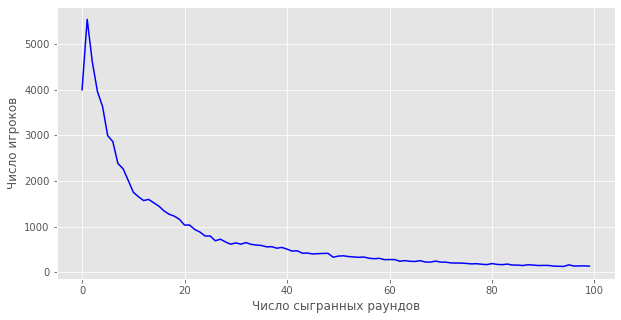

In [21]:
# Подсчет количества игроков для каждого раунда в игре
plot_df = df.groupby('sum_gamerounds')['userid'].count()
# Построение графика распределения игроков, сыгравших от 0 до 100 раундов
plt.figure(figsize = (10, 5))
ax = plot_df.head(100).plot(color='blue')
ax.set_xlabel("Число сыгранных раундов")
ax.set_ylabel("Число игроков");

На графике выше мы видим, что около 4000 пользователей, установивших игру, не сыграли ни одного раунда. Многие игроки сыграли лишь пару раундов, а некоторые настолько увлеклись, что прошли более 80 раундов.

Разработчики игр заинтересованы в том, чтобы пользователь был вовлечен в игру и возвращался в неё снова и снова. Общей метрикой вовлеченности пользователей, используемой в игровой индустрии, является показатель удержания (retention).

Чтобы детальнее посмотреть на этот показатель в двух группах, построим воронку действий пользователей после загрузки приложения.

In [22]:
amount_of_users = df.userid.nunique()

gate_30_data = df[df["version"]=="gate_30"]
gate_40_data = df[df["version"]=="gate_40"]
stages = ["Загрузили", "Сыграли первый раунд", "Удержание 1-го дня", "Удержание 7-го дня"]

values_30 = [gate_30_data.userid.nunique(), gate_30_data[gate_30_data["sum_gamerounds"]>0].userid.nunique(), 
             gate_30_data.retention_1.sum(), gate_30_data.retention_7.sum()] 

percentage_30 = [str(round(values_30[i]/amount_of_users*100, 3)) + "% пользователей" + "<br>"
                 + str(round(values_30[i]/gate_30_data.userid.nunique()*100, 3)) + "% группы" for i in range(len(values_30))]

values_30 = pd.DataFrame(dict(number=values_30, stage=stages, percentage=percentage_30))
values_30["группа"] = "gate_30"

values_40 = [gate_40_data.userid.nunique(), gate_40_data[gate_40_data["sum_gamerounds"]>0].userid.nunique(), 
             gate_40_data.retention_1.sum(), gate_40_data.retention_7.sum()] 

percentage_40 = [str(round(values_40[i]/amount_of_users*100, 3)) + "% пользователей" + "<br>"
                 + str(round(values_40[i]/gate_40_data.userid.nunique()*100, 3)) + "% группы" for i in range(len(values_40))]

values_40 = pd.DataFrame(dict(number=values_40, stage=stages, percentage=percentage_40))
values_40["группа"] = "gate_40"

funnel_data = pd.concat([values_30, values_40], axis=0)

fig = px.funnel(funnel_data, x='number', y='stage', color='группа', text="percentage", title="Конверсия игрового приложения")
fig.show()

Можно отметить два интересных факта:

* Разница в удержании 1-го дня в двух группах составляет почти 0.6 %
* Разница в удержании 7-го дня в двух группах составляет 0.82 %

# 3. Удержание пользователей первого дня (1-day retention) 

Посмотрим как выглядит удержание 1 дня по группам.

In [23]:
df.groupby('version').retention_1.mean()

version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64

Наблюдается небольшое ухудшение в удержании первого дня, если ворота расположены на 40-м уровне (44.2%) в сравнении с контрольной группой, где ворота остались на 30-м уровне (44.8%). Разница около 0.6% кажется небольшой, но может оказаться существенной, если пользователей много. Давайте проверим значимость этого эффекта. Будем использовать односторонний тест о равенстве долей. 

$$
\begin{aligned}
&H_0: \hspace{2mm} p_{40} = p_{30} \\
&H_1: \hspace{2mm} p_{40} < p_{30} 
\end{aligned}
$$


In [24]:
from statsmodels.stats.proportion import proportions_ztest

alpha = 0.05                    # уровень значимости = 5%

df_agg = df.groupby('version').retention_1.agg(['sum', 'count', 'mean'])
df_agg

,sum,count,mean
version,,,
gate_30,20034,44700,0.448188
gate_40,20119,45489,0.442283


In [25]:
n_obs = df_agg['count'].values  # размеры выборок
m_obs = df_agg['sum'].values    # число успехов
p_obs = df_agg['mean'].values   # доли

z_obs, p_val =  proportions_ztest(m_obs, 
                                  n_obs, 
                                  value=0, 
                                  alternative='larger')

print(f"Наблюдаемое значение z-статистики: {z_obs:.3}") 
print(f"P-value: {p_val:.3}") 

Наблюдаемое значение z-статистики: 1.78
P-value: 0.0372


<strong>Гипотеза о равенсве долей отвергается на $5\%$ уровне значимости. Попробуем реализовать тест вручную.</strong>

In [26]:
alpha = 0.05                                       # уровень значимости = 5%
n1,n2 = n_obs[0], n_obs[1]                         # размеры выборок
m1,m2 = m_obs[0], m_obs[1]                         # число успехов

p1, p2 = p_obs[0], p_obs[1]                        # точеные оценки долей 
diff = p1 - p2                                     # разность долей

P = (m1 + m2)/(n1 + n2)          
diff_std = np.sqrt(P*(1 - P)*(1/n1 + 1/n2))        # стандартное отклонение разности
                                    
z_obs = diff/diff_std                              # наблюдаемое значение статистики 
z_crit = stats.norm.ppf(1 - alpha)                 # критическое значение статистики

print(f'{z_obs:.3} не попадает в ({-z_crit:.3} , {z_crit:.3}) => Нулевая гипотеза отвергается')

1.78 не попадает в (-1.64 , 1.64) => Нулевая гипотеза отвергается


Результаты совпали. 
Для наглядности отобразим на графике наблюдаемое и критическое значение статистики.

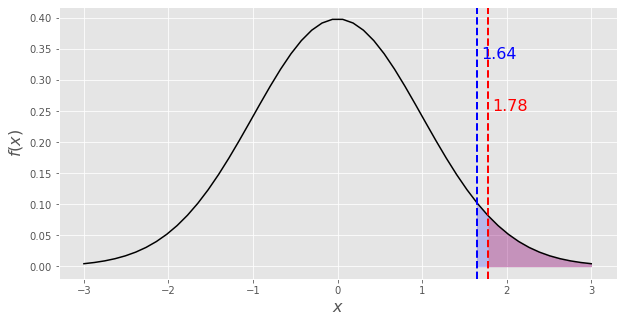

In [27]:
plt.figure(figsize = (10, 5))
x = np.linspace(-3, 3)
pdf = stats.norm().pdf(x)

plt.plot(x, pdf, color="black")
plt.ylabel("$f(x)$", fontsize=16)
plt.xlabel("$x$", fontsize=16)
y_max = plt.ylim()[1]

statistics = ['z_crit', 'z_obs']
params = dict(zip(statistics, [(z_crit, 0.05, z_crit, 3, 'b'),
                                       (z_obs, 0.05, z_obs, 3, 'r')]))

for i in range(len(statistics)):
    statistic, text_margin, left_bound, right_bound, color = params[statistics[i]]
        
    plt.axvline(statistic, color=color, linestyle="--", lw=2)
    h = 0.8 if statistics[i].split('_')[-1] == 'crit' else 0.6
    plt.text(statistic + text_margin, 
                h*y_max, round(statistic, 2), color=color, fontsize=16)
        
    xq = np.linspace(left_bound, right_bound)
    yq = stats.norm().pdf(xq)
    plt.fill_between(xq, 0, yq, color=color, alpha=0.2)

Видно, что z-значение совсем немного превосходит пороговое.

Посмотрим на оценку мощности этого эксперимента.

Статистическая мощность - это вероятность отклонения основной (или нулевой) гипотезы в случае, когда конкурирующая (или альтернативная) гипотеза верна. Чем выше мощность статистического теста, тем меньше вероятность совершить ошибку второго рода. 

In [28]:
# стандартизированный размер эффекта
# p1, p2 - точеные оценки долей 
# n1, n2 - размеры выборок
effect = (p1 - p2) / np.sqrt((n1* (p1*(1-p1)) + n2 * (p2*(1-p2))) / (n1 + n2))
effect

0.011882103556501381

In [29]:
ratio = n_obs[1]/n_obs[0] # отношение размеров выборок
ratio

1.0176510067114093

In [30]:
from statsmodels.stats.power import zt_ind_solve_power

zt_ind_solve_power(effect_size=effect, 
                   nobs1=sum(n_obs), 
                   alpha=0.05, 
                   power=None, 
                   ratio=ratio,
                   alternative='larger')

0.8131003647824975

В нашем случае мощность теста приблизительно равно 81%, что является стандартной величиной, которую обычно закладывают в АБ-тесты.

<strong>Мы выяснили, что 1-day retention в группе с воротами на 30-ом уровне значимо больше данного показателя в группе на 40-ом уровне.
Однако есть вероятность, что после одного дня игры часть пользователей не достигла 30-го или даже 40-го уровня, поэтому расположение первых ворот могло оказать лишь незначительное влияние на поведение пользователей после первого дня.</strong>

# 4. Удержание седьмого дня (7-day retention) 

Cпустя неделю после установки, уже больше игроков пройдут 40 уровней, поэтому имеет смысл посмотреть на удержание седьмого дня. 

In [31]:
df.groupby('version').retention_7.mean()

version
gate_30    0.190201
gate_40    0.182000
Name: retention_7, dtype: float64

Как и с 1-day retention, мы видим, что 7-day retention немного ниже (18.2%), когда ворота находятся на 40-м уровне, чем на 30-м (19.0%). Эта разница уже больше, чем для удержания первого дня, возможно игроки имели больше времени на то, чтобы столкнуться с первыми воротами. Мы также видим, что удержание 7-го дня в целом ниже, чем удержание 1-го - спустя неделю намного меньше людей всё ещё заходит в игру. По-прежнему возикает вопрос: а значима ли эта разница. Для проверки также используем односторонний тест о равенстве долей.

In [32]:
from statsmodels.stats.proportion import proportions_ztest

alpha = 0.05                    # уровень значимости = 5%

df_agg = df.groupby('version').retention_7.agg(['sum', 'count', 'mean'])
df_agg

,sum,count,mean
version,,,
gate_30,8502,44700,0.190201
gate_40,8279,45489,0.182000


In [33]:
n_obs = df_agg['count'].values  # размеры выборок
m_obs = df_agg['sum'].values    # число успехов
p_obs = df_agg['mean'].values   # доли

z_obs, p_val =  proportions_ztest(m_obs, n_obs, value=0, alternative='larger')

print(f"Наблюдаемое значение статистики: {z_obs:.3}") 
print(f"P-значение: {p_val:.3}") 

Наблюдаемое значение статистики: 3.16
P-значение: 0.000777


<strong>Гипотеза о равенстве долей отвергается на $5\%$ уровне значимости. Отметим, что величина p-value в этом тесте сильно меньше.</strong>

In [34]:
alpha = 0.05                                       # уровень значимости = 5%
n1,n2 = n_obs[0], n_obs[1]                         # размеры выборок
m1,m2 = m_obs[0], m_obs[1]                         # число успехов

p1, p2 = p_obs[0], p_obs[1]                        # точеные оценки долей 
diff = p1 - p2                                     # разность долей

P = (m1 + m2)/(n1 + n2)          
diff_std = np.sqrt(P*(1 - P)*(1/n1 + 1/n2))        # стандартное отклонение разности
                                    
z_obs = diff/diff_std                              # наблюдаемое значение статистики 
z_crit = stats.norm.ppf(1 - alpha)                 # критическое значение статистики

print(f'{z_obs:.3} не попадает в ({-z_crit:.3} , {z_crit:.3}) => Нулевая гипотеза отвергается')

3.16 не попадает в (-1.64 , 1.64) => Нулевая гипотеза отвергается


Отобразим на графике наблюдаемое и критическое значение статистики.

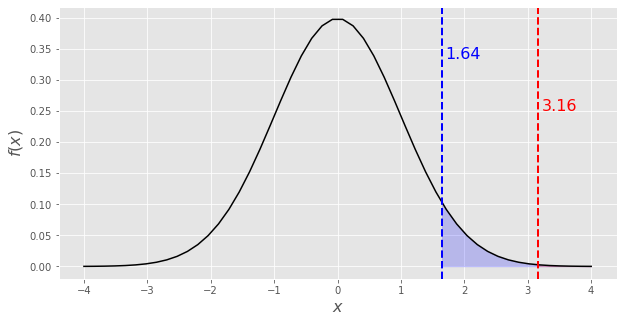

In [35]:
plt.figure(figsize = (10, 5))
x = np.linspace(-4, 4)
pdf = stats.norm().pdf(x)

plt.plot(x, pdf, color="black")
plt.ylabel("$f(x)$", fontsize=16)
plt.xlabel("$x$", fontsize=16)
y_max = plt.ylim()[1]

statistics = ['z_crit', 'z_obs']
params = dict(zip(statistics, [(z_crit, 0.05, z_crit, 4, 'b'),
                                       (z_obs, 0.05, z_obs, 4, 'r')]))

for i in range(len(statistics)):
    statistic, text_margin, left_bound, right_bound, color = params[statistics[i]]
        
    plt.axvline(statistic, color=color, linestyle="--", lw=2)
    h = 0.8 if statistics[i].split('_')[-1] == 'crit' else 0.6
    plt.text(statistic + text_margin, 
                h*y_max, round(statistic, 2), color=color, fontsize=16)
        
    xq = np.linspace(left_bound, right_bound)
    yq = stats.norm().pdf(xq)
    plt.fill_between(xq, 0, yq, color=color, alpha=0.2)

<strong>Видим, что разница сильно значима. Перестановка ворот на 40-й уровень снизит 7-дневное удержание на 0.82%.</strong> 

# Результаты АБ-тестирования

Мы выяснили, что превышение удержания 1-го и 7-го дня в группе с воротами на 30-ом уровне по сравнению с группой с воротами на 40-ом уровне статистически значимо. Значит, если мы хотим поддерживать удержание клиентов на высоком уровне, нам <strong>не следует</strong> сдвигать ворота с 30-го на 40-й уровень.

Но почему удержание пользователей выше, когда ворота расположены раньше? Возможно так проявляется эффект привыкания, пользователь получает меньше удовольствия от деятельности, когда она продолжается длительное время. Заставляя игроков сделать паузу, когда они достигают 30-го уровня, мы продлеваем им удовольствие от игры, в результате чего они не теряют интерес. И напротив, сдвигая ворота к 40-му уровню мы даем игрокам возможность наиграться и просто заскучать.